<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15304 entries, 0 to 15303
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 15304 non-null  int64  
 1   gender             15304 non-null  object 
 2   age                15304 non-null  float64
 3   hypertension       15304 non-null  int64  
 4   heart_disease      15304 non-null  int64  
 5   ever_married       15304 non-null  object 
 6   work_type          15304 non-null  object 
 7   Residence_type     15304 non-null  object 
 8   avg_glucose_level  15304 non-null  float64
 9   bmi                15304 non-null  float64
 10  smoking_status     15304 non-null  object 
 11  stroke             15304 non-null  int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 1.4+ MB
id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type          

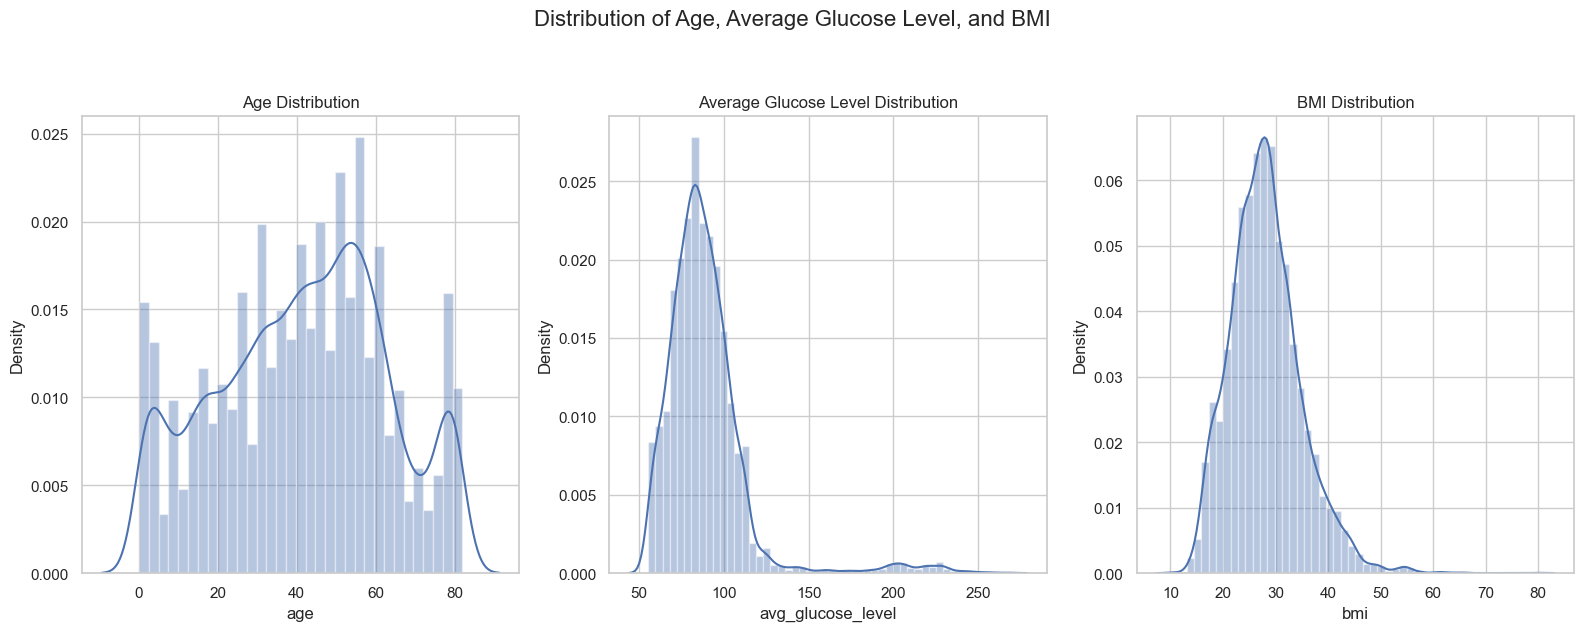

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Chosen threshold: 0.8970000000000007
Predicted positive ratio with new threshold: 0.040182946749428294
New Accuracy: 0.9447892845475335
New Precision: 0.3252032520325203
New Recall: 0.31746031746031744
New F1 Score: 0.321285140562249


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV


# 从文件加载数据
path = r"C:\Users\11953\M2_ISDS\ML_PROJET\\"


data_train = pd.read_csv(path+"train.csv")
data_test = pd.read_csv(path+"test.csv")

data_train.info()

missing_values = data_train.isnull().sum()
print(missing_values)
print(data_train.describe())
print(data_train.columns)

# 列分析，首先分析性别
print(data_train['smoking_status'].value_counts())

sns.set(style="whitegrid")
plt.figure(figsize=(16, 6))  # 调整图表大小
plt.subplot(1, 3, 1)
sns.distplot(data_train['age'])
plt.title('Age Distribution')  # 添加子图标题
plt.subplot(1, 3, 2)
sns.distplot(data_train['avg_glucose_level'])
plt.title('Average Glucose Level Distribution')  # 添加子图标题
plt.subplot(1, 3, 3)
sns.distplot(data_train['bmi'])
plt.title('BMI Distribution')  # 添加子图标题
plt.suptitle('Distribution of Age, Average Glucose Level, and BMI', fontsize=16, y=1.05)
plt.tight_layout()
plt.show()

# 删除不确定的值，这是一个好的开始，但我们也需要设置类权重
data_train = data_train[data_train['gender'] != 'Other']

# 分类特征和数值特征
X = data_train.drop(['id', 'stroke'], axis=1)
y = data_train['stroke']

# ...（之前的代码略）

# 分类特征和数值特征
categorical_features = X.select_dtypes(include=['object']).columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns

# 构建预处理管道
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# 应用预处理并分割数据集
X_preprocessed = preprocessor.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42, stratify=y)

# 接下来，您可以继续用上述的逻辑回归模型，类权重和网格搜索代码

# 初始化逻辑回归模型，并设置 class_weight='balanced'
log_reg = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)

# 设置逻辑回归模型的参数网格
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

# 配置网格搜索（注意我们搜索的是 'log_reg__C'，因为它现在在一个管道内）
grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='f1_weighted', verbose=1)

# 拟合网格搜索（注意：现在我们使用的是 X_train 和 y_train，而不是预处理后的 X）
grid_search.fit(X_train, y_train)

# 获取最佳参数和最佳模型
best_parameters = grid_search.best_params_

# 获取最佳参数和最佳模型
best_model = grid_search.best_estimator_

# 拟合最佳模型（确保使用整个训练集）
best_model.fit(X_train, y_train)

# 对测试集进行概率预测
y_proba = best_model.predict_proba(X_test)[:, 1]

# 初始化一个很低的阈值
threshold = 0.01
predicted_positive_ratio_new = 1  # 初始化为一个大于目标的值

# 不断增加阈值直到找到合适的值

while threshold < 1.0 and predicted_positive_ratio_new > 0.04:
    # 应用新的阈值来确定类别
    y_pred_new_threshold = (y_proba >= threshold).astype(int)
    # 计算新阈值下的阳性比率
    predicted_positive_ratio_new = np.mean(y_pred_new_threshold)
    
    # 如果阳性比率低于我们的目标（比如说0.05，给一点缓冲区域），停止迭代
    if predicted_positive_ratio_new <= 0.0412963930998431:
        break
    
    # 否则，增加阈值
    threshold += 0.001

# 打印选择的阈值和对应的阳性比率
print(f'Chosen threshold: {threshold}')
print(f'Predicted positive ratio with new threshold: {predicted_positive_ratio_new}')

# 如果您想看到使用新阈值的性能指标，您可以计算并打印这些指标
new_accuracy = accuracy_score(y_test, y_pred_new_threshold)
new_precision = precision_score(y_test, y_pred_new_threshold)
new_recall = recall_score(y_test, y_pred_new_threshold)
new_f1 = f1_score(y_test, y_pred_new_threshold)

print(f'New Accuracy: {new_accuracy}')
print(f'New Precision: {new_precision}')
print(f'New Recall: {new_recall}')
print(f'New F1 Score: {new_f1}')

In [6]:
print(np.count_nonzero(y_pred_new_threshold))
print(sum(y_pred_new_threshold) / len(y_pred_new_threshold))

123
0.040182946749428294
